In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from BoardDetector import ContourBoardDetector
from PlotDrawer import PlotDrawer

boardDetector = ContourBoardDetector({
    "resolution_area": 720 * 1280
})

plotter = PlotDrawer()

# cv2.imwrite(filename, var)

In [3]:
img = cv2.imread("NoCandidateTest.png")

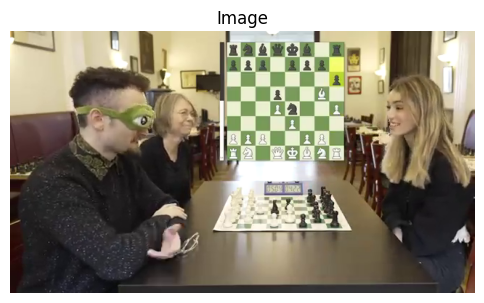

In [4]:
plotter.show_image(img)

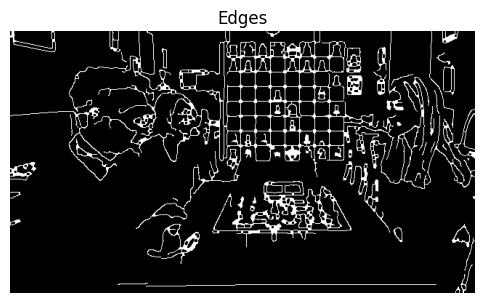

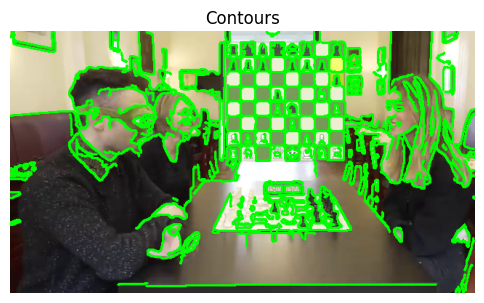

315 contours


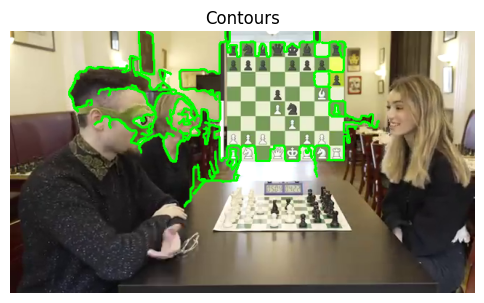

Size filtered 1


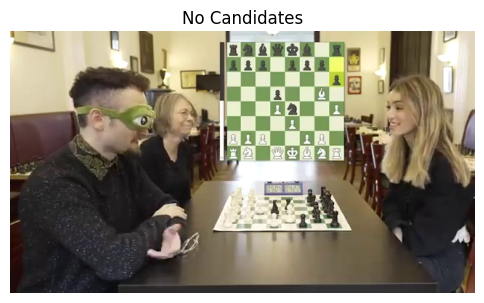

No candidates found.


In [51]:
def apply_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges  = cv2.Canny(blurred, 50, 100)
    kernel = np.ones((3,3), np.uint8)
    edges_thick = cv2.dilate(edges, kernel, iterations=1)
    edges_open  = cv2.morphologyEx(edges_thick, cv2.MORPH_OPEN, kernel, iterations=1)
    edges_fixed = cv2.erode(edges_open, kernel, iterations=1)

    return edges_fixed

edges = apply_edge_detection(img)

vertical, horizontal = boardDetector.count_grid_lines(edges)
plotter.show_image(edges, "Edges")

contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
plotter.draw_contours(img, contours)
print(len(contours), "contours")
filtered = 0
candidates = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < 720 * 1280 * 0.01:
        continue
    
    filtered += 1
    plotter.draw_contours(img, [contour])
    rect = cv2.minAreaRect(contour)
    (cx, cy), (w, h), angle = rect
    
    if abs(angle % 180) != 0.0 and abs(angle != 90.0):
        continue

    if w == 0 or h == 0:
        continue

    # Test square aspect ratio with 10% error
    aspect_ratio = max(w, h) / min(w, h)
    if 0.9 < aspect_ratio < 1.1:
        box = cv2.boxPoints(rect)
        box = box.astype(np.intp)
        candidates.append((box, area, angle))
    
print("Size filtered", filtered)

if not candidates:
    plotter.show_image(img, "No Candidates")
    print("No candidates found.")

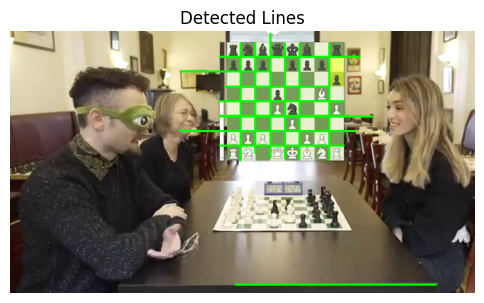

In [45]:
edges = apply_edge_detection(img)
lines = cv2.HoughLinesP(edges, 1, np.pi/180,
                            threshold=150, minLineLength=0.3*min(edges.shape),
                            maxLineGap=15)

plotter.draw_lines_on_image(img, lines)